In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
tf.__version__

'2.10.0'

# Traning and testing sets preparation

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [3]:
training_set = train_datagen.flow_from_directory('data/train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 shuffle=False,
                                                 class_mode = 'categorical')

Found 1200 images belonging to 4 classes.


In [4]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('data/test', 
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            shuffle=False,
                                            class_mode = 'categorical')

Found 396 images belonging to 4 classes.


# Model creation

### First model:

In [ ]:
#cnn = tf.keras.models.Sequential()
#cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(64, 64, 3)))
#cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
#cnn.add(tf.keras.layers.MaxPooling2D((2, 2)))
#cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
#cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
#cnn.add(tf.keras.layers.MaxPooling2D((2, 2)))
#cnn.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
#cnn.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
#cnn.add(tf.keras.layers.MaxPooling2D((2, 2)))
#cnn.add(tf.keras.layers.Flatten())
#cnn.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
#cnn.add(tf.keras.layers.Dense(4, activation='softmax'))

### Second model:

In [ ]:
#cnn = tf.keras.models.Sequential()
#cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)))
#cnn.add(tf.keras.layers.AveragePooling2D(pool_size=2, strides=2))
#cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
#cnn.add(tf.keras.layers.AveragePooling2D(pool_size=2, strides=2))
#cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
#cnn.add(tf.keras.layers.Flatten())
#cnn.add(tf.keras.layers.Dense(128, activation='relu'))
#cnn.add(tf.keras.layers.Dense(4, activation='softmax'))

### Third model:

In [5]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, input_shape=(64,64,3)))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=4, activation='softmax'))

In [6]:
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [7]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d (MaxPooling2D  (None, 32, 32, 3)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 128)               921728    
                                                                 
 dense_1 (Dense)             (None, 4)                 5

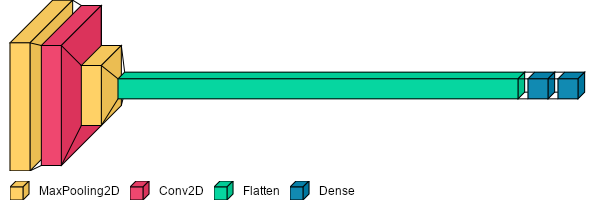

In [8]:
import visualkeras
visualkeras.layered_view(cnn, legend=True) 

from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(cnn, legend=True, font=font, to_file='model_layered3.png')

# The training process

In [9]:
hist=cnn.fit(x = training_set, validation_data = test_set, epochs = 50)

Epoch 1/50
38/38 [==============================] - 7s 173ms/step - loss: 1.9589 - accuracy: 0.2133 - val_loss: 1.3851 - val_accuracy: 0.2500
Epoch 2/50
38/38 [==============================] - 5s 144ms/step - loss: 1.4028 - accuracy: 0.2258 - val_loss: 1.3841 - val_accuracy: 0.2500
Epoch 3/50
38/38 [==============================] - 5s 144ms/step - loss: 1.3813 - accuracy: 0.2800 - val_loss: 1.3719 - val_accuracy: 0.3636
Epoch 4/50
38/38 [==============================] - 6s 145ms/step - loss: 1.3641 - accuracy: 0.3433 - val_loss: 1.3412 - val_accuracy: 0.4848
Epoch 5/50
38/38 [==============================] - 5s 143ms/step - loss: 1.3587 - accuracy: 0.3617 - val_loss: 1.2957 - val_accuracy: 0.4773
Epoch 6/50
38/38 [==============================] - 5s 144ms/step - loss: 1.4003 - accuracy: 0.4817 - val_loss: 1.3267 - val_accuracy: 0.6162
Epoch 7/50
38/38 [==============================] - 5s 143ms/step - loss: 1.2690 - accuracy: 0.4475 - val_loss: 1.1386 - val_accuracy: 0.4773
Epoch 

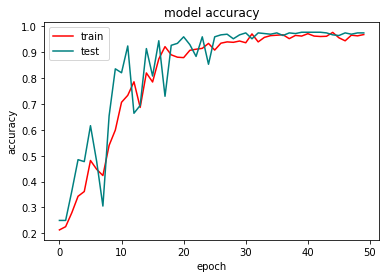

In [10]:
plt.plot(hist.history['accuracy'],color='red')
plt.plot(hist.history['val_accuracy'], color='teal')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Model_accuracy3.jpg',dpi=500)
plt.show()

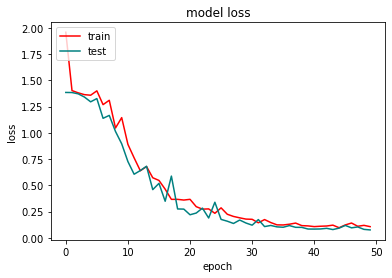

In [11]:
plt.plot(hist.history['loss'], color='red')
plt.plot(hist.history['val_loss'], color='teal')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Model_loss3.jpg',dpi=500)
plt.show()

# Image prediction

In [12]:
import keras.utils as image
import cv2

In [13]:
def predict_on_img(folder):
    dictionary = {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}
    key_list = list(dictionary.keys())
    value_list = list(dictionary.values())
    images = []
    for filename in os.listdir(folder):
        test_image = image.load_img('data/prediction/' + filename, target_size = (64, 64))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        result = cnn.predict(test_image/255.0)
        prediction = np.argmax(result, axis = 1)
        prediction = int(prediction)
        pos = value_list.index(prediction)
        
        im = cv2.imread(os.path.join(folder,filename))
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(im, key_list[prediction], (10,60), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.imwrite(filename+'_prediction3.jpg', im)
        if im is not None:
            images.append(im)

In [14]:
predict_on_img('data/prediction')

1/1 [==============================] - 0s 23ms/step


# Confussion matrix

In [15]:
predictions = cnn.predict(test_set)
predictions = np.argmax(predictions, axis = 1)

13/13 [==============================] - 1s 93ms/step


In [16]:
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 0,

In [17]:
results_validation =cnn.evaluate(test_set, batch_size=32)

13/13 [==============================] - 1s 87ms/step - loss: 0.0748 - accuracy: 0.9747


In [18]:
print("test loss, test acc:", results_validation)

test loss, test acc: [0.07483682781457901, 0.9747474789619446]


In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(test_set.classes, predictions)

0.9747474747474747

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_set.classes, predictions)
cm

array([[97,  0,  0,  2],
       [ 0, 99,  0,  0],
       [ 0,  2, 97,  0],
       [ 3,  2,  1, 93]], dtype=int64)

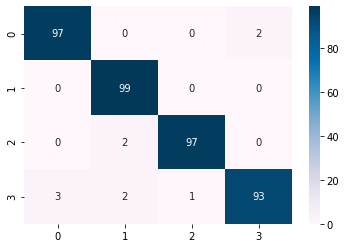

In [21]:
import seaborn as sns
sns.heatmap(cm, annot=True,cmap='PuBu');

In [22]:
from sklearn.metrics import classification_report
print(classification_report(test_set.classes, predictions))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97        99
           1       0.96      1.00      0.98        99
           2       0.99      0.98      0.98        99
           3       0.98      0.94      0.96        99

    accuracy                           0.97       396
   macro avg       0.97      0.97      0.97       396
weighted avg       0.97      0.97      0.97       396



# Model saving

In [23]:
model_json = cnn.to_json()
with open('cnn3.json','w') as json_file:
    json_file.write(model_json)

In [24]:
from keras.models import save_model
network_saved = save_model(cnn, 'weights3.hdf5')

# Model loading

In [ ]:
with open('cnn2.json', 'r') as json_file:
    json_saved_model = json_file.read()
    json_saved_model

In [ ]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('weights2.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
network_loaded.summary()